# Allen Mouse Common Coordinate Framework (2020 version)

Allen Mouse Brain Common Coordinate Framework (CCFv3, [Wang et al, 2020](https://doi.org/10.1016/j.cell.2020.04.007)) is a 3D reference space is an average brain at 10um voxel resolution created from serial two-photon tomography images of 1,675 young adult C57Bl6/J mice. Using multimodal reference data, the entire brain parcellated directly in 3D, labeling every voxel with a brain structure spanning 43 isocortical areas and their layers, 314 subcortical gray matter structures, 81 fiber tracts, and 8 ventricular structures. The 2020 version adds new annotations for layers of the Ammon’s horn (CA), main olfactory bulb (MOB) and minor modification of surrounding fiber tracts.

CCFv3 is used in informatics pipelines and online applications to analyze, visualize and integrate multimodal and multiscale data sets in 3D, and is openly accessible for research use.

The purpose of this notebook is to provide an overview of the data assets and information associated with the Allen CCFv3 through example use cases.

You need to be connected to the internet to run this notebook and that you have already downloaded the data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import SimpleITK as sitk
import pathlib

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

The commented section that calls ``from_local_cache`` can be used instead when a download of the data already exists on disk or running on CodeOcean with the attached Allen Brain Cell Atlas or similar mounting of the AWS s3 bucket as a directory through [s3fs-fuse](https://github.com/s3fs-fuse/s3fs-fuse) or similar.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)

# download_base = Path('../../data/abc_atlas') # Path to the already downloaded data or s3fs-fuse mount.
# abc_cache = AbcProjectCache.from_local_cache(download_base)

abc_cache.current_manifest

'releases/20240330/manifest.json'

## Data Overview

### Reference template and parcellations

There are 3 volumetric data files associated with AllenCCFv3. The "average_template_10" volume is the anatomical template of the CCF constructed as the shape and intensity average of 1675 specime brains. The "annotation_10" volume is the parcellation of the brain with respect to a heirachical partonomy of anatomical structures. The "annotation_boundary_10" volume is a mask that identifies all the voxel with on the boundary of a parcellation to support data visualization. The volumes are stored in compressed NIFTI (.nii.gz) format. In this notebook  uses the [SimpleITK](https://simpleitk.org/) library to open the volume. 

In [3]:
abc_cache.list_data_files('Allen-CCF-2020')

['annotation_10', 'annotation_boundary_10', 'average_template_10']

In [4]:
file = abc_cache.get_data_path(directory='Allen-CCF-2020', file_name='average_template_10')
average_template_image = sitk.ReadImage(file)
average_template_array = sitk.GetArrayViewFromImage(average_template_image)

file = abc_cache.get_data_path(directory='Allen-CCF-2020', file_name='annotation_10')
annotation_image = sitk.ReadImage(file)
annotation_array = sitk.GetArrayViewFromImage(annotation_image)

file = abc_cache.get_data_path(directory='Allen-CCF-2020', file_name='annotation_boundary_10')
annotation_boundary_image = sitk.ReadImage(file)
annotation_boundary_array = sitk.GetArrayViewFromImage(annotation_boundary_image)

We define a helper function to print out some basic metadata about a volume

In [5]:
# Function to print out image information
def image_info(img):
    print(f'size: {img.GetSize()} voxels')
    print(f'spacing: {img.GetSpacing()} mm')
    print(f'direction: {img.GetDirection()}')
    print(f'origin: {img.GetOrigin()}')

Each volume is of size 1320 x 800 x 1140 voxels with voxel dimension being 10 x 10 x 10 micrometers. The volume is ASL orientation such that first (x) axis is anterior-to-posterior, the second (y) axis is superior-to-inferior (dorsal-to-ventral) and third (z) axis is left-to-right.

In [6]:
image_info(average_template_image)

size: (1320, 800, 1140) voxels
spacing: (0.009999999776482582, 0.009999999776482582, 0.009999999776482582) mm
direction: (-0.0, 0.0, -1.0, 1.0, -0.0, 0.0, 0.0, -1.0, 0.0)
origin: (5.695000171661377, -5.349999904632568, 5.21999979019165)


In [7]:
spacing = average_template_image.GetSpacing()
voxel_volume = spacing[0] * spacing[1] * spacing[2]
print("voxel volume in mm^3:", "%0.2E" % voxel_volume)

voxel volume in mm^3: 1.00E-06


We define a helper function to visualize the sanme coronal section of the average template, annotation and boundary volumes

In [8]:
def plot_section(slice, cmap = plt.cm.Greys_r, fig_width = 6, fig_height = 6):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None:
        plt.imshow(slice, cmap=cmap)
    else :
        plt.imshow(slice)
    plt.axis("off")
    return fig, ax

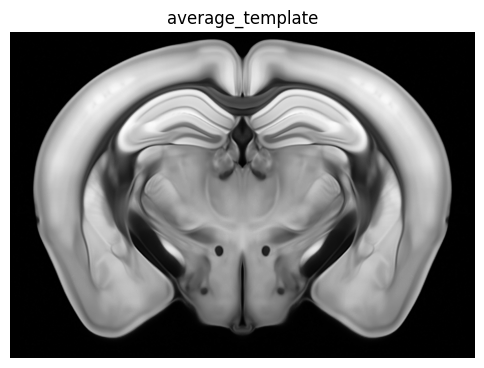

In [9]:
zindex = 720
zslice = np.transpose(average_template_array[:, :, zindex])
fig, ax = plot_section(zslice)
res = ax.set_title('average_template')

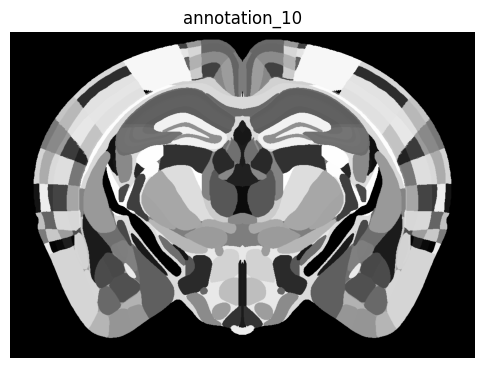

In [10]:
zslice = np.transpose(annotation_array[:, :, zindex])
fig, ax = plot_section(zslice)
res = ax.set_title('annotation_10')

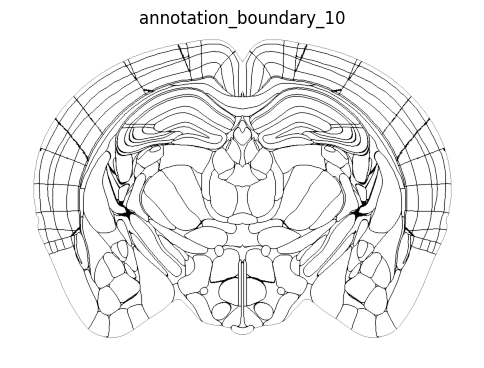

In [11]:
zslice = np.transpose(annotation_boundary_array[:, :, zindex])
fig, ax = plot_section(zslice, cmap=plt.cm.Greys)
res = ax.set_title('annotation_boundary_10')

### Anatomical structures and parcellation annotation

### Parcellations

The annotation volume represents tiling of set of parcellations. Each row of the parcellation dataframe has a label (human readable string that is unique in the database), a parcellation index representing the value in the annotation volume and the number of voxel and volume of that parcellation.

In [12]:
parcellation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020', file_name='parcellation')
parcellation.set_index('parcellation_index', inplace=True)
print("number of parcellations:", len(parcellation))
parcellation

number of parcellations: 688


,label,voxel_count,volume_mm3
parcellation_index,,,
987,AllenCCF-Annotation-2020-997,3564320,3.564320
63,AllenCCF-Annotation-2020-68,256520,0.256520
657,AllenCCF-Annotation-2020-667,232608,0.232608
1288,AllenCCF-Annotation-2020-526157192,371584,0.371584
1289,AllenCCF-Annotation-2020-526157196,112222,0.112222
...,...,...,...
135,AllenCCF-Annotation-2020-140,405256,0.405256
140,AllenCCF-Annotation-2020-145,499566,0.499566
148,AllenCCF-Annotation-2020-153,461680,0.461680


### Parcellation term sets

For the purpose of ABC atlas visualization and analysis, we have created a simplifed 5 level anatomical heirarchy. Each of these level is represented as a parcellation term set. Each term set consists of a set of ordered terms. Each term set has a label (human readable string that is unique in the database), a name, description and order among the term sets.

In [13]:
parcellation_term_set = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020', file_name='parcellation_term_set')
parcellation_term_set.set_index('label', inplace=True)
print("number of term sets:", len(parcellation_term_set))
parcellation_term_set

number of term sets: 5


,description,name,parcellation_terminology_label,term_set_order,parent_term_set_label
label,,,,,
AllenCCF-Ontology-2017-ORGA,organ,organ,AllenCCF-Ontology-2017,0,NaN
AllenCCF-Ontology-2017-CATE,mouse brain anatomical catergories,category,AllenCCF-Ontology-2017,1,AllenCCF-Ontology-2017-ORGA
AllenCCF-Ontology-2017-DIVI,mouse brain divisions,division,AllenCCF-Ontology-2017,2,AllenCCF-Ontology-2017-CATE
AllenCCF-Ontology-2017-STRU,mouse brain structures,structure,AllenCCF-Ontology-2017,3,AllenCCF-Ontology-2017-DIVI
AllenCCF-Ontology-2017-SUBS,mouse brain substructures,substructure,AllenCCF-Ontology-2017,4,AllenCCF-Ontology-2017-STRU


### Parcellation terms and term set membership

A parcellation term represents an anatomical structure at a single heirarchy level. Each term has a label (human readable string that is unique in the database), a name, acronym, reference atlas color as hex triplet or as RGB values.

In [14]:
parcellation_term = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020', file_name='parcellation_term')
parcellation_term.set_index('label', inplace=True)
print("number of terms:", len(parcellation_term))
parcellation_term.head(5)

number of terms: 1631


,acronym,name,color_hex_triplet,graph_order,identifier,red,green,blue,parent_identifier
label,,,,,,,,,
AllenCCF-Ontology-2017-997,brain,brain,#FFFFFF,0.0,MBA:997,255,255,255,NaN
AllenCCF-Ontology-2017-8,grey,Basic cell groups and regions,#BFDAE3,1.0,MBA:8,191,218,227,MBA:997
AllenCCF-Ontology-2017-567,CH,Cerebrum,#B0F0FF,2.0,MBA:567,176,240,255,MBA:8
AllenCCF-Ontology-2017-688,CTX,Cerebral cortex,#B0FFB8,3.0,MBA:688,176,255,184,MBA:567
AllenCCF-Ontology-2017-695,CTXpl,Cortical plate,#70FF70,4.0,MBA:695,112,255,112,MBA:688


A parcellation is a member of at most one parcellation term set. This membership is represented as a row in the parcellation term set memership dataframe.

In [15]:
parcellation_term_set_membership = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                                    file_name='parcellation_term_set_membership')
print("number of memberships:", len(parcellation_term_set_membership))
parcellation_term_set_membership.head(5)

number of memberships: 1293


,parcellation_term_label,parcellation_term_set_label,parent_term_label,term_order
0,AllenCCF-Ontology-2017-997,AllenCCF-Ontology-2017-ORGA,NaN,0
1,AllenCCF-Ontology-2017-8,AllenCCF-Ontology-2017-CATE,AllenCCF-Ontology-2017-997,1
2,AllenCCF-Ontology-2017-1009,AllenCCF-Ontology-2017-CATE,AllenCCF-Ontology-2017-997,2
3,AllenCCF-Ontology-2017-73,AllenCCF-Ontology-2017-CATE,AllenCCF-Ontology-2017-997,3
4,AllenCCF-Ontology-2017-315,AllenCCF-Ontology-2017-DIVI,AllenCCF-Ontology-2017-8,1


### Parcellation to parcellation term membership

The association between a parcellation and parcellation term is represented as "parcellation to parcellation term membership" within the context of anatomical structure level.  It is expected that a parcellation in only associated with one term within a specific term set.

In [16]:
parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                           file_name='parcellation_to_parcellation_term_membership')
print("number of memberships:", len(parcellation_annotation))
parcellation_annotation

number of memberships: 3440


,parcellation_label,parcellation_term_label,parcellation_term_set_label,parcellation_index,voxel_count,volume_mm3,color_hex_triplet,red,green,blue,parcellation_term_name,parcellation_term_acronym,parcellation_term_set_name,term_set_order,term_order,parent_term_label
0,AllenCCF-Annotation-2020-997,AllenCCF-Ontology-2017-997,AllenCCF-Ontology-2017-ORGA,987,3564320,3.564320,#FFFFFF,255,255,255,brain,brain,organ,0,0,NaN
1,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-997,AllenCCF-Ontology-2017-ORGA,63,256520,0.256520,#FFFFFF,255,255,255,brain,brain,organ,0,0,NaN
2,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-8,AllenCCF-Ontology-2017-CATE,63,256520,0.256520,#BFDAE3,191,218,227,Basic cell groups and regions,grey,category,1,1,AllenCCF-Ontology-2017-997
3,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-315,AllenCCF-Ontology-2017-DIVI,63,256520,0.256520,#70FF71,112,255,113,Isocortex,Isocortex,division,2,1,AllenCCF-Ontology-2017-8
4,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-184,AllenCCF-Ontology-2017-STRU,63,256520,0.256520,#268F45,38,143,69,"Frontal pole, cerebral cortex",FRP,structure,3,1,AllenCCF-Ontology-2017-315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435,AllenCCF-Annotation-2020-145,ABC-Ontology-2023-V4-structure,AllenCCF-Ontology-2017-STRU,140,499566,0.499566,#AAAAAA,170,170,170,"fourth ventricle, unassigned",V4-unassigned,structure,3,367,AllenCCF-Ontology-2017-145
3436,AllenCCF-Annotation-2020-145,ABC-Ontology-2023-V4-substructure,AllenCCF-Ontology-2017-SUBS,140,499566,0.499566,#AAAAAA,170,170,170,"fourth ventricle, unassigned",V4-unassigned,substructure,4,885,ABC-Ontology-2023-V4-structure
3437,AllenCCF-Annotation-2020-153,ABC-Ontology-2023-V4r-substructure,AllenCCF-Ontology-2017-SUBS,148,461680,0.461680,#AAAAAA,170,170,170,lateral recess,V4r,substructure,4,886,AllenCCF-Ontology-2017-153
3438,AllenCCF-Annotation-2020-164,ABC-Ontology-2023-c-structure,AllenCCF-Ontology-2017-STRU,159,432,0.000432,#AAAAAA,170,170,170,"central canal, spinal cord/medulla",c,structure,3,369,AllenCCF-Ontology-2017-164


## Example use cases

### Aggregate parcellations and voxels per term

We can obtain parcellation and voxel count per parcellation annotation term using the pandas groupby function

In [17]:
# Count the number of parcellation associated with each parcellation term
term_parcellation_count = parcellation_annotation.groupby(['parcellation_term_label'])[['parcellation_index']].count()
term_parcellation_count.columns = ['number_of_parcellations']
term_parcellation_count.sort_values('number_of_parcellations', inplace=True, ascending=False)
term_parcellation_count

,number_of_parcellations
parcellation_term_label,
AllenCCF-Ontology-2017-997,687
AllenCCF-Ontology-2017-8,597
AllenCCF-Ontology-2017-315,241
AllenCCF-Ontology-2017-1009,81
AllenCCF-Ontology-2017-313,59
...,...
AllenCCF-Ontology-2017-10703,1
AllenCCF-Ontology-2017-10704,1
AllenCCF-Ontology-2017-1072,1


In [18]:
# Count the number of voxels associated with each parcellation term
term_voxel_count = parcellation_annotation.groupby(['parcellation_term_label'])[['voxel_count','volume_mm3']].sum()
term_voxel_count.sort_values('voxel_count', inplace=True, ascending=False)
term_voxel_count

,voxel_count,volume_mm3
parcellation_term_label,,
ABC-Ontology-2023-unassigned-substructure,697783214,697.783214
ABC-Ontology-2023-unassigned-structure,697783214,697.783214
ABC-Ontology-2023-unassigned-organ,697783214,697.783214
ABC-Ontology-2023-unassigned-division,697783214,697.783214
ABC-Ontology-2023-unassigned-category,697783214,697.783214
...,...,...
ABC-Ontology-2023-c-structure,432,0.000432
ABC-Ontology-2023-CA1-substructure,6,0.000006
AllenCCF-Ontology-2017-1051,4,0.000004


In [19]:
# Join counts with the term dataframe
term_with_counts = parcellation_term.join(term_parcellation_count['number_of_parcellations'], how='inner')
term_with_counts.index.name = 'label'
term_with_counts = term_with_counts.join(term_voxel_count[['voxel_count','volume_mm3']])
term_with_counts[['name', 'number_of_parcellations', 'voxel_count', 'volume_mm3']]
term_with_counts.head(5)

,acronym,name,color_hex_triplet,graph_order,identifier,red,green,blue,parent_identifier,number_of_parcellations,voxel_count,volume_mm3
label,,,,,,,,,,,,
AllenCCF-Ontology-2017-997,brain,brain,#FFFFFF,0.0,MBA:997,255,255,255,NaN,687,506056786,506.056786
AllenCCF-Ontology-2017-8,grey,Basic cell groups and regions,#BFDAE3,1.0,MBA:8,191,218,227,MBA:997,597,449681182,449.681182
AllenCCF-Ontology-2017-315,Isocortex,Isocortex,#70FF71,5.0,MBA:315,112,255,113,MBA:695,241,123282624,123.282624
AllenCCF-Ontology-2017-184,FRP,"Frontal pole, cerebral cortex",#268F45,6.0,MBA:184,38,143,69,MBA:315,5,973876,0.973876
AllenCCF-Ontology-2017-68,FRP1,"Frontal pole, layer 1",#268F45,7.0,MBA:68,38,143,69,MBA:184,1,256520,0.256520


In [20]:
# validate that term with the same acronym have the same number of voxels
alist = np.unique(term_with_counts['acronym'])
for aa in alist :
    filtered = term_with_counts[term_with_counts['acronym'] == aa]
    vlist = np.unique(filtered['voxel_count'])
    if len(vlist) > 1:
        print(aa, vlist)

The dataframe ``term_with_counts`` is available in the cache as ``parcellation_term_with_counts``.

### Visualizing parcellation annotation at each hierachy level

We can explore the relationship and distribution of parcellations between term sets by creating a pivot table using pandas groupby fuunction. Each row of the resulting dataframe represents a parcellation, each column represents a term set and the value in the table is the name of the term that has been associated with the cluster for that specific term set.

In [21]:
pivot = parcellation_annotation.groupby(['parcellation_index','parcellation_term_set_name'])['parcellation_term_acronym'].first().unstack()
pivot = pivot[parcellation_term_set['name']] # order columns
pivot

parcellation_term_set_name,organ,category,division,structure,substructure
parcellation_index,,,,,
0,unassigned,unassigned,unassigned,unassigned,unassigned
1,brain,grey,HY,TMv,TMv
2,brain,grey,Isocortex,SSp-m,SSp-m6b
5,brain,fiber tracts,lfbs,cst,int
6,brain,grey,P,PSV,PSV
...,...,...,...,...,...
1323,brain,grey,MB,IPN,IPI
1324,brain,grey,MB,IPN,IPDM
1325,brain,grey,MB,IPN,IPDL


In [22]:
name = parcellation_annotation.groupby(['parcellation_index', 'parcellation_term_set_name'])['parcellation_term_name'].first().unstack()
name = name[parcellation_term_set['name']] # order columns
name

parcellation_term_set_name,organ,category,division,structure,substructure
parcellation_index,,,,,
0,unassigned,unassigned,unassigned,unassigned,unassigned
1,brain,Basic cell groups and regions,Hypothalamus,"Tuberomammillary nucleus, ventral part","Tuberomammillary nucleus, ventral part"
2,brain,Basic cell groups and regions,Isocortex,"Primary somatosensory area, mouth","Primary somatosensory area, mouth, layer 6b"
5,brain,fiber tracts,lateral forebrain bundle system,corticospinal tract,internal capsule
6,brain,Basic cell groups and regions,Pons,Principal sensory nucleus of the trigeminal,Principal sensory nucleus of the trigeminal
...,...,...,...,...,...
1323,brain,Basic cell groups and regions,Midbrain,Interpeduncular nucleus,"Interpeduncular nucleus, intermediate"
1324,brain,Basic cell groups and regions,Midbrain,Interpeduncular nucleus,"Interpeduncular nucleus, dorsomedial"
1325,brain,Basic cell groups and regions,Midbrain,Interpeduncular nucleus,"Interpeduncular nucleus, dorsolateral"


We can also obtain parcellation term color pivot tables in the same way

In [23]:
color = parcellation_annotation.groupby(['parcellation_index', 'parcellation_term_set_name'])['color_hex_triplet'].first().unstack()
color = color[parcellation_term_set['name']] # order columns
color.columns = ['%s_color' % x for x in color.columns]
color

,organ_color,category_color,division_color,structure_color,substructure_color
parcellation_index,,,,,
0,#000000,#000000,#000000,#000000,#000000
1,#FFFFFF,#BFDAE3,#E64438,#FF4C3E,#FF4C3E
2,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064
5,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
6,#FFFFFF,#BFDAE3,#FF9B88,#FFAE6F,#FFAE6F
...,...,...,...,...,...
1323,#FFFFFF,#BFDAE3,#FF64FF,#FFA6FF,#FFA6FF
1324,#FFFFFF,#BFDAE3,#FF64FF,#FFA6FF,#FFA6FF
1325,#FFFFFF,#BFDAE3,#FF64FF,#FFA6FF,#FFA6FF


In [24]:
channels = {}
for c in ['red', 'blue', 'green'] :
    df = parcellation_annotation.groupby(['parcellation_index', 'parcellation_term_set_name'])[c].first().unstack()
    df = df[parcellation_term_set['name']] # order columns
    df.columns = ['%s' % (x) for x in color.columns]
    channels[c] = df

In [25]:
channels['red']

,organ_color,category_color,division_color,structure_color,substructure_color
parcellation_index,,,,,
0,0,0,0,0,0
1,255,191,230,255,255
2,255,191,112,24,24
5,255,204,204,204,204
6,255,191,255,255,255
...,...,...,...,...,...
1323,255,191,255,255,255
1324,255,191,255,255,255
1325,255,191,255,255,255


The dataframes created here (``pivot``, ``name``, ``color``, ``channels``) are stored in the cache as ``parcellation_to_parcellation_term_membership_acronym``, ``parcellation_to_parcellation_term_membership_name``, ``parcellation_to_parcellation_term_membership_color``, and ``parcellation_to_parcellation_term_membership_<channel>``.

We define a helper function to colorized parcellation by its reference atlas color for each anatomical level

In [26]:
def colorize(zslice, term_set):

    # create a 3d array to store rgb image
    sshape = zslice.shape
    colorized = np.zeros((sshape[0], sshape[1], 3), dtype=np.uint8)

    for i,c in enumerate(['red', 'green', 'blue']):
        temp = np.zeros((sshape[0], sshape[1]), dtype=np.uint8)
        temp.flat[:] = channels[c].loc[zslice.flat[:], '%s_color' % term_set]
        colorized[:, :, i] = temp

    return colorized

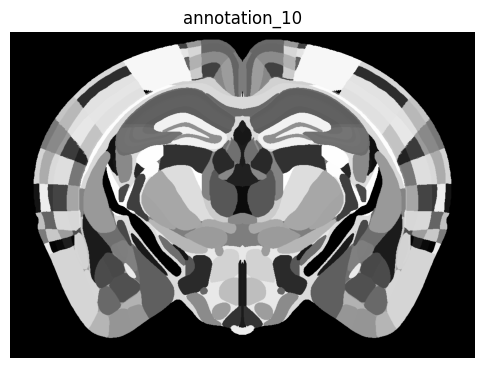

In [27]:
zindex = 720
zslice = np.transpose(annotation_array[:, :, zindex])
fig, ax = plot_section(zslice)
res = ax.set_title('annotation_10')

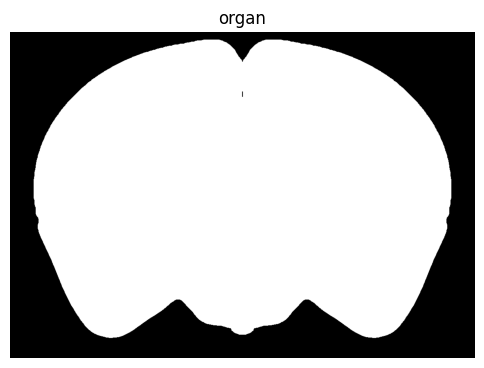

In [28]:
term_set = 'organ'
colorized = colorize(zslice, term_set)
fig, ax = plot_section(colorized)
res = ax.set_title(term_set)

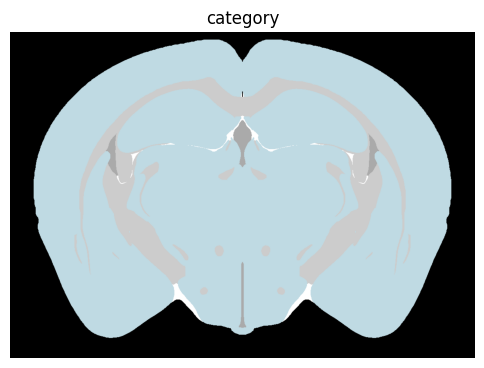

In [29]:
term_set = 'category'
colorized = colorize(zslice, term_set)
fig, ax = plot_section(colorized)
res = ax.set_title(term_set)

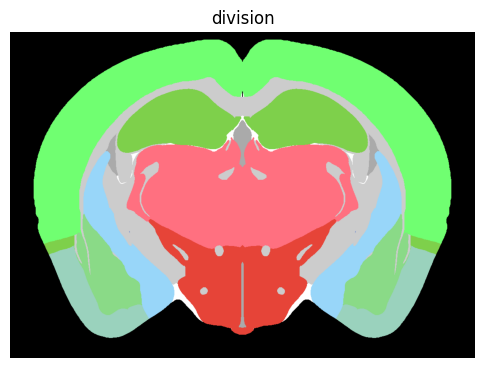

In [30]:
term_set = 'division'
colorized = colorize(zslice, term_set)
fig, ax = plot_section(colorized)
res = ax.set_title(term_set)

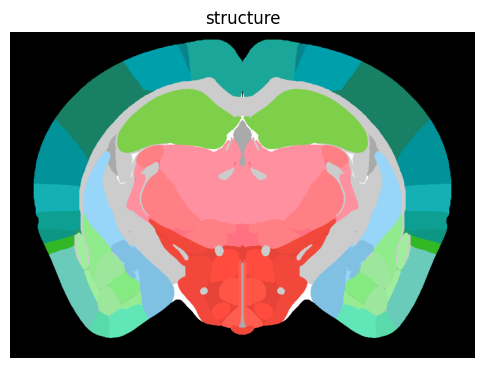

In [31]:
term_set = 'structure'
colorized = colorize(zslice, term_set)
fig, ax = plot_section(colorized)
res = ax.set_title(term_set)

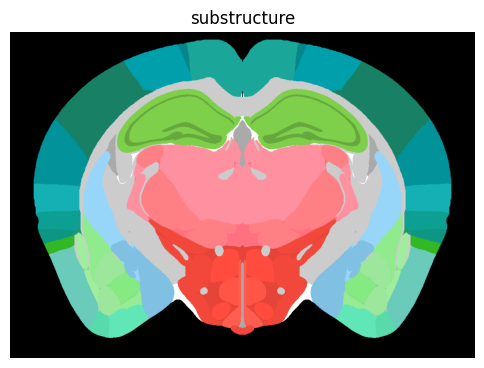

In [32]:
term_set = 'substructure'
colorized = colorize(zslice, term_set)
fig, ax = plot_section(colorized)
res = ax.set_title(term_set)